# EM 알고리즘
EM 알고리즘은 복잡한 최대 가능도 추정(Maximum Likelihood Estimation) 문제를 해결하게끔 해주는 알고리즘이다. 모집단의 매개변수가 늘어나면 최대 가능도 추정 문제를 직접 풀기 위한 계산에 제약이 생긴다. 따라서, EM 알고리즘이 개발되기 전에는 매개변수가 많은 최대 가능도 추정 문제를 해결하는데 있어서 큰 어려움이 있었다.

EM 알고리즘은 복잡한 최대 가능도 함수를 두 부분으로 나눈뒤, Expectation step(**E-step**)과 Maximization step(**M-step**)을 반복함으로써, 최대 가능도 추정치를 구하는 알고리즘이다.

EM 알고리즘을 이용하는 알고리즘에는 대표적으로 가우시안 혼합 분류법이 있다.

## 가우시안 혼합 분류법
잘 알려진 데이터 분류 기법 중 하나이다. 샘플 데이터, $x_1, ..., x_n$들이 서로 다른 분포를 가지는 $K$개의 클래스, $C_1, ..., C_K$로 부터 추출 되었을 때, 각각의 데이터 들이 어느 분포에서 나왔는지 판단하는 알고리즘이다.

### 가정

각각의 클래스는 정규 분포를 따르며, $j$번째 클래스가 선택될 확률은 $\pi_j$ 이고, 해당 클래스의 평균 벡터와 공분산 매트릭스는 $\mu_j, \sigma_j$이다.
이때 각각의 샘플은 다음의 분포를 가진다.
$$f(x; \theta) = \sum_{j=1}^K \frac{\pi_j}{(2 \pi |\sigma_j|)^{d/2}} \exp \left( -\frac{1}{2} (x-\mu_j)^T\sigma_j^{-1}(x-\mu_j) \right)$$

### 해법
따라서 최대 가능도 함수는 다음과 같다.
$$\mathcal{L}(\theta) = \prod_{i=1}^n \sum_{j=1}^K \frac{\pi_j}{(2 \pi |\sigma_j|)^{d/2}} \exp \left( -\frac{1}{2} (x_i-\mu_j)^T\sigma_j^{-1}(x_i-\mu_j) \right) $$
$$\theta = (\mu_1, ..., \mu_K, \sigma_1, ..., \sigma_K, ..., \pi_1, ..., \pi_K)$$

$i$번째 샘플의 클래스를 나타내는 잠재변수 $Z^i = (z^i_1, ..., z^i_K)$를 정의하게 되면, $i$번째 데이터가 $j$ 클래스에 있을 때의 조건부 확률 분포를 다음과 같이 구할 수 있다.
$$f\left(x_i \mid z^i_j = 1, \theta \right) = \frac{1}{(2 \pi |\sigma_j|)^{d/2}} \exp \left( -\frac{1}{2} (x_i-\mu_j)^T\sigma_j^{-1}(x_i-\mu_j) \right) =: p(x_i; \mu_j, \sigma_j)$$

해당 잠재 변수의 확률 분포 함수를 $\Pi^i_j := P(z_j = 1 \mid x_i))$ 정의한다. 그러면 우리는 EM 알고리즘에 적용할 다음과 같은 M-step과 E-step을 얻는다. 

### E-step

$${\Pi^i_j}^{(k+1)} = \frac{ {\pi_j}^{(k)} p\left(x_i ; \mu_j^{(k)},\sigma_j^{(k)}\right) }{ \sum_{l=1}^{K} {\pi_l}^{(k)} p\left(x_i ; \mu_l^{(k)}\sigma_l^{(k)}\right) }$$

### M-step

$$\mu_j^{(k+1)} = \frac{\sum_{i=1}^{n} {\Pi^i_j}^{(k+1)} x_i }{\sum_{i=1}^{n} {\Pi^i_j}^{(k+1)} } $$
$$\sigma_j^{(k+1)} = \frac{\sum_{i=1}^{n} {\Pi^i_j}^{(k+1)} \left(x_i - \mu_j^{(k)}\right)\left(x_i - \mu_j^{(k)}\right)^T}{\sum_{i=1}^{n} {\Pi^i_j}^{(k+1)} } $$
$$\pi_j^{(k+1)} = \frac{\sum_{i=1}^{n} {\Pi^i_j}^{(k+1)} x_i }{n } $$

다음은 Python에 내장되어 있는 가우시안 혼합 분류법 모듈을 이용하여 데이터 분류를 한 코드이다.

### 모듈 가져오기

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

### 시각화를 위한 타원 그리는 함수

In [2]:
colors = ['navy', 'turquoise', 'darkorange']


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

### 분류할 데이터 불러오기

In [3]:
iris = datasets.load_iris()

### 학습시킬 데이터와 검증할 데이터 나누기

In [4]:
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

### 학습 데이터를 이용하여 모델 학습후 검증하기

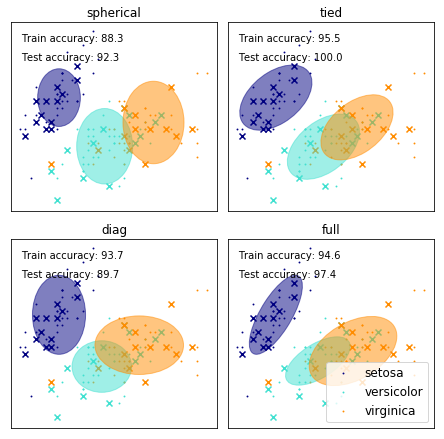

In [5]:
estimators = dict((cov_type, GaussianMixture(n_components=n_classes,
                   covariance_type=cov_type, max_iter=20, random_state=0))
                  for cov_type in ['spherical', 'diag', 'tied', 'full'])

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=iris.target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))



plt.show()

## Hidden Markov Model
시게열 데이터 분석 기법 중 하나이다. 관측된 시계열 데이터 $x_1, ..., x_n$들은 각각 관측이 되지 않은 **Hidden state** $z_1, ... z_n$에 의존하는 분포로 부터 추출된다. 각각의 Hidden state로 이루어진 시계열 $z_1,...,z_n$이 Markov process를 따른다고 가정할때, HMM은 Hidden state에 대한 transition matrix와 관측된 시계열 데이터가 어떤 Hidden state에서 추출 되었는지 판단하는 알고리즘이다.

Hidden Markov Model학습을 이용하기 위해서 hmmlearn이라는 module을 사용한다.

In [6]:
import numpy as np
from scipy.stats import rv_discrete
from scipy.stats import bernoulli

import pymc3 as pm
import theano.tensor as tt

import seaborn as sns
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.externals import joblib

In [7]:
np.random.seed(830)

### 모델 생성

In [8]:
model = hmm.MultinomialHMM(n_components=2, n_iter=100)
model.startprob_ = np.array([1,0])
model.transmat_ = np.array([[0.95,0.05],
                          [0.3,0.7]])
model.n_features = 6
model.emissionprob_ = np.array([[1/6,1/6,1/6,1/6,1/6/1,6],[0.06,0.06,0.06,0.06,0.06,0.7]])

In [9]:
X, Z = model.sample(30000)

In [10]:
Loaded = np.array([np.linspace(0,29999,30000)[t] for t in range(30000) if Z[t]==1])

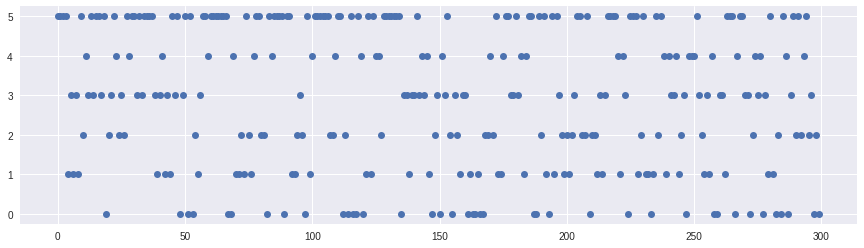

In [11]:
plt.figure(figsize=(15,4))
plt.plot(X[:300], 'o')
plt.show()

### 모델 학습
1. n_components : hidden state의 개수
2. n_iter : EM algorithm 최대 반복 횟수

In [12]:
n_iter=10000
remodel = hmm.MultinomialHMM(n_components=2, n_iter=n_iter, tol=0.0001)

result = remodel.fit(X)

In [8]:
joblib.dump(remodel, "hmmremodel_n_iter_{}.pkl".format(n_iter))
joblib.dump(result, "hmmresult_n_iter_{}.pkl".format(n_iter))

['hmmresult_n_iter_10000.pkl']

In [ ]:
remodel=joblib.load("hmmremodel_n_iter_{}.pkl".format(n_iter))
result=joblib.load("hmmresult_n_iter_{}.pkl".format(n_iter))

### 결과 분석

Transition matrix
original
[[ 0.95  0.05]
 [ 0.3   0.7 ]]
predicted
[[ 0.94751564  0.05248436]
 [ 0.28850696  0.71149304]]
[[ 0.16661276  0.16766359  0.16635328  0.16700854  0.16378575  0.16857608]
 [ 0.06544322  0.04689907  0.05734452  0.07322602  0.07404748  0.68303969]]


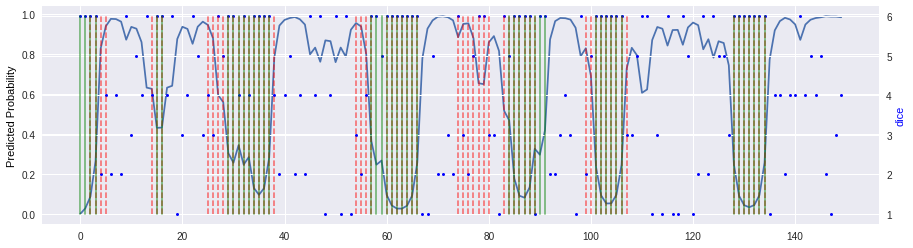

In [13]:
Predict = result.predict(X)

Predict_proba = result.predict_proba(X)

Predict_Fair_proba = np.array([Predict_proba[t][0] for t in range(30000)])

Predict_Loaded = np.array([np.arange(0,30000)[t] for t in range(30000) if Predict_Fair_proba[t]<0.5])

print("Transition matrix")
print("original")
print(model.transmat_)
print("predicted")
print(remodel.transmat_)
print(remodel.emissionprob_)

fig, ax1 = plt.subplots(figsize=(15,4))
start=0
end=150
ax1.plot(np.arange(start,end),Predict_Fair_proba[start:end])
ax1.set_ylabel('Predicted Probability', color='black')

ax2 = ax1.twinx()
ax2.plot(np.arange(start,end),X[start:end]+1,'bo',ms=3)
ax2.set_ylabel('dice', color='b')

flague=True
i=0
while flague:
    if Loaded[i]>=start:
        ax2.plot((Loaded[i],Loaded[i]),(1,6),'--', color = "red", alpha=0.5)
    i+=1
    if Loaded[i]>=end:
        flague=False

flague=True
i=0
while flague:
    if Predict_Loaded[i]>=start:
        ax2.plot((Predict_Loaded[i],Predict_Loaded[i]),(1,6),'-', color = "green", alpha=0.5)
    i+=1
    if Predict_Loaded[i]>=end:
        flague=False
        
plt.show()